In [49]:
#initial package imports
from pycocotools.coco import COCO
from pylabel import importer
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


#Loading COCO dataset
json_dir='/home/ferds/Desktop/ferds_model_training/common_touched_office_objects.v3i.coco/train/_annotations.coco.json'
img_dir='/home/ferds/Desktop/ferds_model_training/common_touched_office_objects.v3i.coco/train'
coco = COCO(json_dir)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [13]:
#EDA of COCO format dataset
with open(json_dir, 'r') as f:
    root = json.load(f)
root.keys()

# Basic High Level Information
n_images = len(root['images'])
n_annot = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]

print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_annot)
print('Number of classes: ', n_categ)
print('Max-min-avg-height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max-min-avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Number of images:  862
Number of bounding boxes:  3389
Number of classes:  10
Max-min-avg-height:  720 720 720
Max-min-avg width:  1280 1280 1280


In [50]:
#Import the dataset into the pylable schema
#Check if dataset is there
dataset = importer.ImportCoco(json_dir, path_to_images=img_dir, name="CTOO")
dataset.df.head(5)

/home/ferds/Desktop/ferds_model_training/.coco/lib/python3.12/site-packages/pylabel/importer.py:127: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("", inplace=True)


,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_iscrowd,ann_keypoints,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,/home/ferds/Desktop/ferds_model_training/commo...,20240921_155004_jpg.rf.e1fc135d21a294955afe83b...,,0,1280,720,,,328.0,56.0,...,0.0,,,,,1,chair,tables-chairs-doors,,1
1,/home/ferds/Desktop/ferds_model_training/commo...,20240921_155004_jpg.rf.e1fc135d21a294955afe83b...,,0,1280,720,,,578.0,74.0,...,0.0,,,,,1,chair,tables-chairs-doors,,1
2,/home/ferds/Desktop/ferds_model_training/commo...,20240921_155004_jpg.rf.e1fc135d21a294955afe83b...,,0,1280,720,,,832.0,75.0,...,0.0,,,,,1,chair,tables-chairs-doors,,1
3,/home/ferds/Desktop/ferds_model_training/commo...,20240921_155004_jpg.rf.e1fc135d21a294955afe83b...,,0,1280,720,,,1118.0,73.0,...,0.0,,,,,1,chair,tables-chairs-doors,,1
4,/home/ferds/Desktop/ferds_model_training/commo...,20240921_155004_jpg.rf.e1fc135d21a294955afe83b...,,0,1280,720,,,494.0,43.0,...,0.0,,,,,1,chair,tables-chairs-doors,,1


In [51]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Class counts:\n{dataset.analyze.class_counts}")

Number of images: 862
Class counts:
cat_name
chair                945
table                511
lightswitch          461
door                 350
door_handle          314
person               295
monitor              249
computer_keyboard    171
computer_mouse        93
                       5
Name: count, dtype: int64


Object distribution should be heatmap char for every class and shows how many images are in the dataset for each class

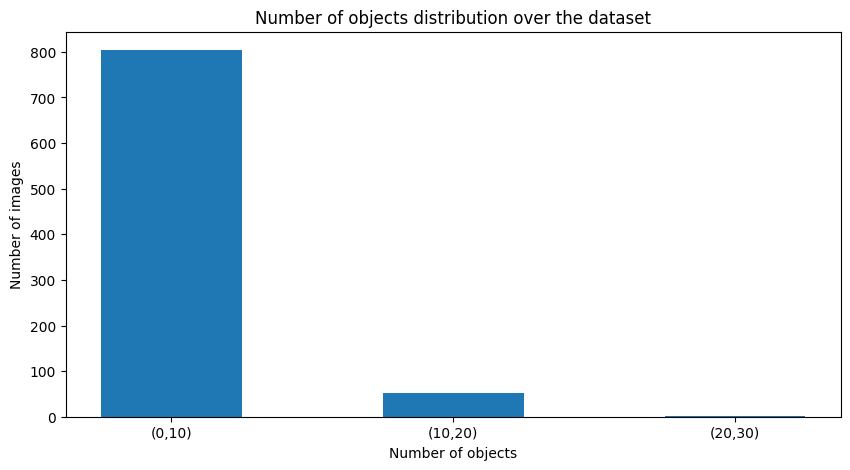

Number of images having atleast one annot:  857
Min number of annot per image:  1
Max number of annot per image:  22
Avg number of annot per image:  3


In [ ]:
#Objects per image distribution



img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one annot: ", len(nboxes_list))
print("Min number of annot per image: ", min_nboxes)
print("Max number of annot per image: ", max_nboxes)
print("Avg number of annot per image: ", avg_nboxes)


Class Distribution should also include a co-occurence matrix to check how many classes are annotated in an image

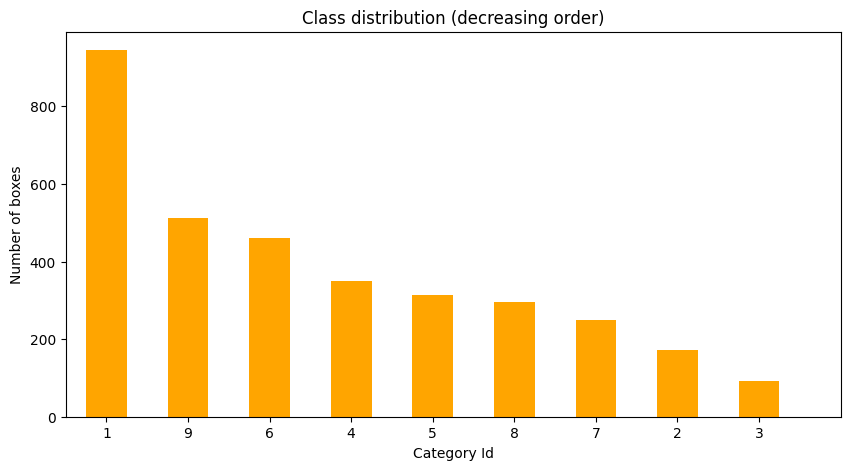

0 -> tables-chairs-doors, 1 -> chair, 2 -> computer_keyboard, 3 -> computer_mouse, 4 -> door, 5 -> door_handle, 6 -> lightswitch, 7 -> monitor, 8 -> person, 9 -> table, 

In [15]:
# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()



categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

In [19]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

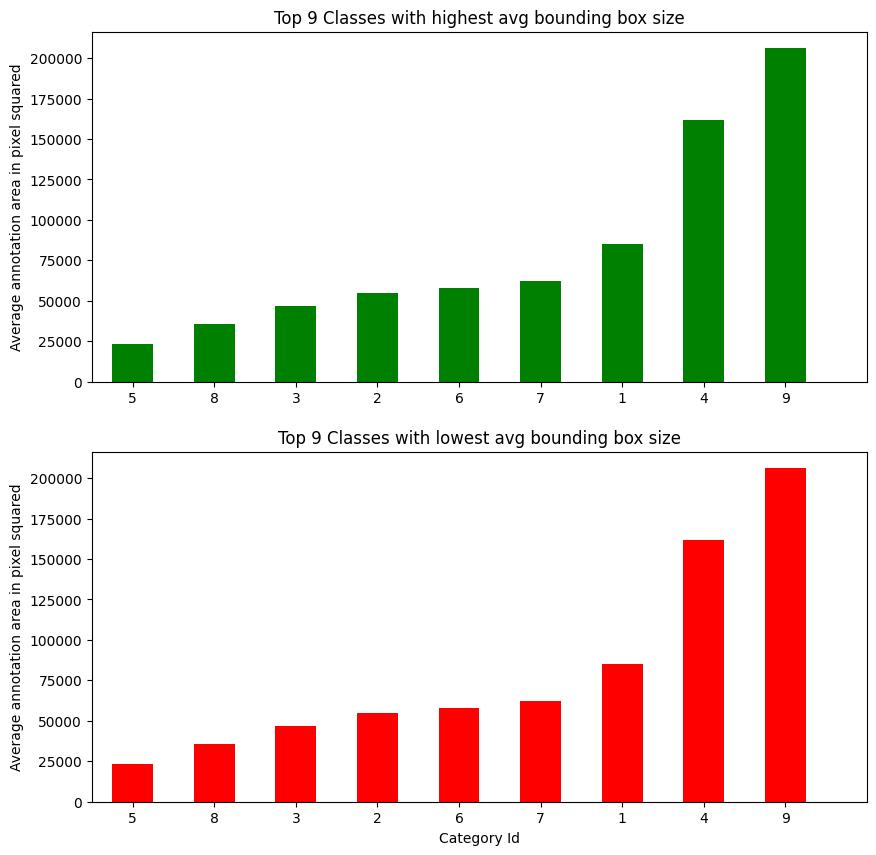

0 -> tables-chairs-doors, 1 -> chair, 2 -> computer_keyboard, 3 -> computer_mouse, 4 -> door, 5 -> door_handle, 6 -> lightswitch, 7 -> monitor, 8 -> person, 9 -> table, 

In [17]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(10,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average annotation area in pixel squared')
plt.title('Top '+str(top)+' Classes with highest avg bounding box size')


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='red')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category Id')
plt.ylabel('Average annotation area in pixel squared')
plt.title('Top '+str(top)+' Classes with lowest avg bounding box size')
plt.show()




categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

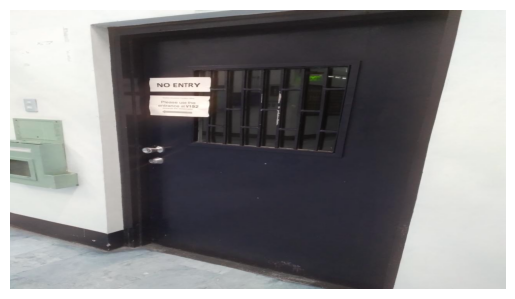

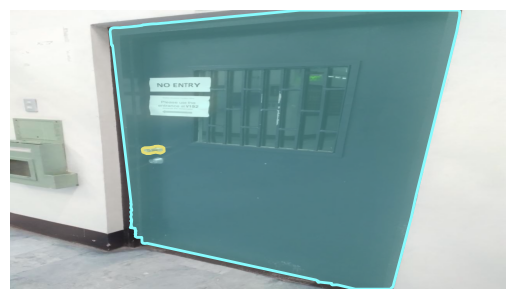

In [37]:
#Sanity check by viewing random annotations and images 
imgIds = coco.getImgIds()
img = coco.loadImgs(imgIds[np.random.randint(0, len(imgIds))])[0]
I = cv2.imread('%s/%s'%(img_dir, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

# Display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

{'id': 19, 'license': 1, 'file_name': 'IMG20240701170936_jpg.rf.e553ffbe01044ada5dca6685c23655d2.jpg', 'height': 720, 'width': 1280, 'date_captured': '2024-10-15T10:08:03+00:00'}


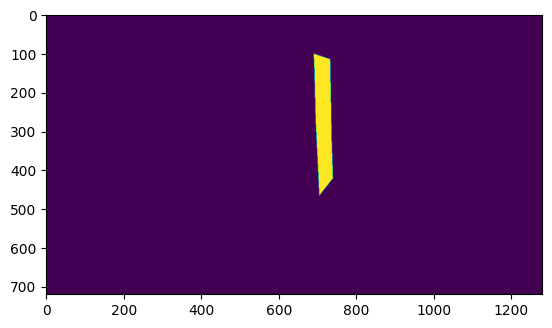

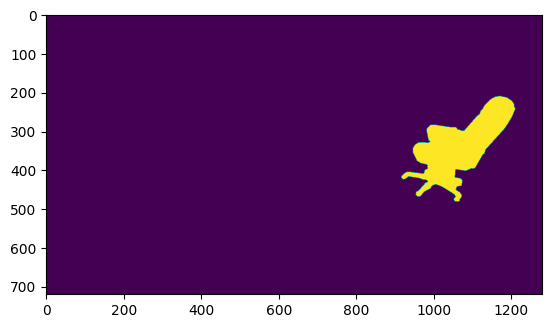

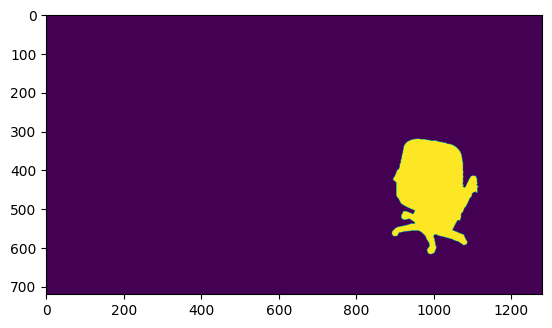

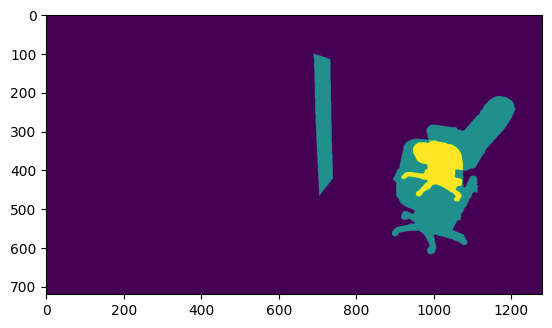

In [48]:
# get binary mask from annotation ids
#input in loadAnns random annotation id
ann = coco.loadAnns([100,400, 600])
# print(ann)
# print(ann['image_id'])
print(coco.imgs[ann[0]['image_id']])
#array should correspond to image size (i.e. 720x1280 image frame)
m = np.zeros((720,1280))
for a in ann:
    mask = coco.annToMask(a)
    plt.imshow(mask)
    plt.show()
    m+=mask
plt.imshow(m)